# Test environment for package development

In [107]:
import math

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
import tqdm

from frugalCopyla.model import Copula_Model
from frugalCopyla import copula_functions as copula_lpdfs

In [108]:
rho = 0.5

In [110]:
input_template = {
'Z': {'dist': dist.Normal, 'formula': {'loc': 'Z ~ 1', 'scale': 'Z ~ 1'}, 'coeffs': {'loc': [0.], 'scale': [1.]}, 'link': {}},
'X': {'dist': dist.Normal, 'formula': {'loc': 'X ~ Z', 'scale': 'X ~ Z'}, 'coeffs': {'loc': [0., rho], 'scale': [0., jnp.sqrt(1 - jnp.square(rho))]}, 'link': {}},
'Y': {'dist': dist.Normal, 'formula': {'loc': 'Y ~ X', 'scale': 'Y ~ 1'}, 'coeffs': {'loc': [-0.5, rho], 'scale': [1.]}, 'link': {}},
'copula': {
    'class': copula_lpdfs.multivar_gaussian_copula_lpdf,
    'vars': ['Z', 'Y'],
    'formula': {'rho_ZY': 'cop ~ 1'},
    'coeffs': {'rho_ZY': [1.]},
    'link': {jax.scipy.special.expit}
}
}

In [111]:
mod = Copula_Model(input_template)

TypeError: 'set' object is not subscriptable

## Rough outline

Ideally, one could specify a (linear) model with a variety of parameters, and generate samples from it. It would bypass the need to play around with a numpyro backend and allow you to generate data purely from a relatively trivial model parameterisation.

**TO DO: NEED TO CHANGE ALL MENTION OF LINK FUNCTIONS TO INVERSE LINK FUCTIONS**

**TO DO: pass the copula class field the actual function rather than just the string**

The input should be a dictionary whose keys label the variables in your model. For each of these, specify in a sub-dictionary:

* `dist`: The distribution the variable is drawn from. These must be selected from `numpyro.distributions`
* `formula`: For each parameter in the chosen distribution, specify its linear model **only using variables defined earlier in the dictionary**. The names of the correct parameters can be found by either [searching the `numpyro` documentation]() or looking at the `arg_constraints` of the distribution by running (using the Normal as an example) : 
```
> numpyro.distributions.Normal.arg_constraints 

{'loc': Real(), 'scale': GreaterThan(lower_bound=0.0)}
```
* `params` (name will most likely change): Specifies the linear coefficients used to generate the primary variable through the linear model. A set of coefficients must be provided for each parameter. Note that the labelling of parameters (e.g. `'formula': {'rate': 'X ~ 1 + Z + A'}, 'params': {'rate': {'x_0': 0., 'x_1': 2., 'x_2': 1}}`) does not affect the linear model. Only the order of the specification matters. For example, `x_0` will be the coefficient of the first variable in the formula (always the intercept) and `x_2` will always be the last.
* `link` allows the user to provide a link function for each of the linear formulas. For example, the command ```'X': {'dist': dist.Exponential, 'formula': {'rate': 'X ~ 1 + Z + A'}, 'params': {'rate': [0., 2., 1.]}, 'link': {'rate': jnp.exp}},``` 
will wrap the linear predictor in an exponential function such that the probabilistic model is $$X \sim \text{Exponential}(\lambda=\exp(2Z + A)).$$ **Note that the link function must have a `jax` base.** If no link function is require, leave it as `None`.
    * Additionally, note that the order of the floats within `'params'` will automatically be the the order they are multiplied to the ordered variables in `'rate'`. **The intercept term will always be the first term in the parsed formula.**

* `copula`: To specify a copula, first choose a `'class'` of copula from [frugalCopyla/copula_functions.py](../frugalCopyla/copula_functions.py). The copula functions will take in keyword arguments to calculate the log-likelihood of the copula factor. 
    * Under `vars`, provide a mapping of the variables linked by the copula and the function arguments using a dictionary. For example, the `multivar_gaussian_copula_lpdf(vars, rhos)` factor takes two variables: a list of random variables (`vars`) and a dictionary of the copula correlation matrix elements (`rhos`). If we wish to simulate a copula between `Z` and `Y`, provide `vars` the list `..., 'vars': ['Z', 'Y']`.
    * Under `'formula'`, specify the form of the linear predictor for the parameters passed to the copula. The coefficients for the linear predictor are specified under `'params'`.
    * Similarly to the other inputs, a link function can be chosen to wrap the linear predictor specified in `'formula'` and `'params'`.

For example, consider the following probabilistic model:
$$ A \sim \text{Bernoulli}(0.5) \newline Z \sim \mathcal{N}(0, 1) \newline X ~ \text{Exponential}(\exp(2Z + A) \newline Y | \text{do}(X) \sim \mathcal{N}(X - 0.5, 1)$$
and a bivariate Gaussian copula between $Z$ and $Y$ parameterised by a fixed covariance term $\rho_{ZY} = logit(1)$

The following model is specfied in `input_dict`.

In [2]:
input_dict = {
    'A': {
        'dist': dist.BernoulliProbs, 
        'formula': {'probs': 'A ~ 1'}, 
        'coeffs': {'probs': [0.5]}, 
        'link': None
    }, 
    'Z': {
        'dist': dist.Normal, 
        'formula': {'loc': 'Z ~ 1', 'scale': 'Z ~ 1'}, 
        'coeffs': {'loc': [0.], 'scale': [1.]}, 
        'link': None
    },
    'X': {
        'dist': dist.Exponential, 
        'formula': {'rate': 'X ~ 1 + Z + A'}, 
        'coeffs': {'rate': [0., 2., 1.]}, 
        'link': {'rate': jnp.exp}
    },
    'Y': {
        'dist': dist.Normal, 
        'formula': {'loc': 'Y ~ 1 + X', 'scale': 'Y ~ 1'}, 
        'coeffs': {'loc': [-0.5, 1.], 'scale': [1.]}, 
        'link': None
    },
    'copula': {
        'class': copula_lpdfs.multivar_gaussian_copula_lpdf, 
        'vars': ['Z', 'Y'], 
        'formula': {'rho_zy': 'c ~ X'}, 
        'coeffs': {'rho_zy': [0.1, 1]}, 
        'link': {'rho_zy': jax.nn.sigmoid}
    }
}

Preparing the `Copula_Model`:

In [3]:
cop_mod = Copula_Model(input_dict)
cop_mod.parsed_model

{'A': {'dist': numpyro.distributions.discrete.BernoulliProbs,
  'formula': {'probs': 'A ~ 1'},
  'coeffs': {'probs': [0.5]},
  'link': {},
  'linear_predictor': {'probs': '0.5'}},
 'Z': {'dist': numpyro.distributions.continuous.Normal,
  'formula': {'loc': 'Z ~ 1', 'scale': 'Z ~ 1'},
  'coeffs': {'loc': [0.0], 'scale': [1.0]},
  'link': {},
  'linear_predictor': {'loc': '0.0', 'scale': '1.0'}},
 'X': {'dist': numpyro.distributions.continuous.Exponential,
  'formula': {'rate': "X ~ 1 + record_dict['Z'] + record_dict['A']"},
  'coeffs': {'rate': [0.0, 2.0, 1.0]},
  'link': {'rate': <CompiledFunction of <function _one_to_one_unop.<locals>.<lambda> at 0x117f8d700>>},
  'linear_predictor': {'rate': "0.0 + 2.0 * record_dict['Z'] + 1.0 * record_dict['A']"}},
 'Y': {'dist': numpyro.distributions.continuous.Normal,
  'formula': {'loc': "Y ~ 1 + record_dict['X']", 'scale': 'Y ~ 1'},
  'coeffs': {'loc': [-0.5, 1.0], 'scale': [1.0]},
  'link': {},
  'linear_predictor': {'loc': "-0.5 + 1.0 * record

We can see whether the model has been parsed correctly by looking at the `'full_formula'` entries in the output.

Currently, the code is set up such that each random variable in the linear model should be fetched from a dictionary named `record_dict`. That is, instead of seeing `Y ~ X + A` we should see `Y ~ record_dict['X'] + record_dict['A']`.

In [4]:
parsed_model = cop_mod.parsed_model
parsed_model

{'A': {'dist': numpyro.distributions.discrete.BernoulliProbs,
  'formula': {'probs': 'A ~ 1'},
  'coeffs': {'probs': [0.5]},
  'link': {},
  'linear_predictor': {'probs': '0.5'}},
 'Z': {'dist': numpyro.distributions.continuous.Normal,
  'formula': {'loc': 'Z ~ 1', 'scale': 'Z ~ 1'},
  'coeffs': {'loc': [0.0], 'scale': [1.0]},
  'link': {},
  'linear_predictor': {'loc': '0.0', 'scale': '1.0'}},
 'X': {'dist': numpyro.distributions.continuous.Exponential,
  'formula': {'rate': "X ~ 1 + record_dict['Z'] + record_dict['A']"},
  'coeffs': {'rate': [0.0, 2.0, 1.0]},
  'link': {'rate': <CompiledFunction of <function _one_to_one_unop.<locals>.<lambda> at 0x117f8d700>>},
  'linear_predictor': {'rate': "0.0 + 2.0 * record_dict['Z'] + 1.0 * record_dict['A']"}},
 'Y': {'dist': numpyro.distributions.continuous.Normal,
  'formula': {'loc': "Y ~ 1 + record_dict['X']", 'scale': 'Y ~ 1'},
  'coeffs': {'loc': [-0.5, 1.0], 'scale': [1.0]},
  'link': {},
  'linear_predictor': {'loc': "-0.5 + 1.0 * record

Looks ok so far. Now we can simulate from the prior using MCMC. Specify the steps for warmup and sampling, the seed (if desired), and whether the joint is `'continuous'`, `'discrete'`, or `'mixed'`. If this last step is not specified correctly you may see an error.

The simulated data is returned as a dictionary of data, along with the inverse cdf'd copula RVs (and their standard normals) of the copula parameters and the samples for the copula parameters:

In [5]:
%%time
sim_data = cop_mod.simulate_data(num_warmup=1000, num_samples=1_000_000, joint_status='mixed', seed=0)
pd.DataFrame(sim_data).describe()

CPU times: user 16 s, sys: 150 ms, total: 16.2 s
Wall time: 16.2 s


,A,X,Y,Z,q_Y,q_Z,rho_zy,std_normal_Y,std_normal_Z
count,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.527549,6.267887e-01,0.125846,0.104367,0.498743,0.533220,0.651325,-0.000942,0.104367
std,0.499241,7.518212e-01,0.909446,0.630022,0.212223,0.212957,0.127989,0.625665,0.630022
min,0.000000,3.318487e-07,-3.449986,-2.704900,0.001161,0.003416,0.524979,-3.045688,-2.704900
25%,0.000000,8.644476e-02,-0.507345,-0.333480,0.337057,0.369386,0.546477,-0.420509,-0.333480
50%,1.000000,3.037324e-01,0.038689,0.081496,0.493418,0.532476,0.599584,-0.016499,0.081496
75%,1.000000,8.950458e-01,0.670886,0.519997,0.659447,0.698467,0.730083,0.410954,0.519997
max,1.000000,3.379622e+00,3.314239,3.630758,0.999881,0.999859,0.970102,3.674262,3.630708


## Didelez Model

Let's draw data from the model discussed in Evans and Didelez (2021):

In [14]:
didelez_spec = {
    'A': {
        'dist': dist.BernoulliProbs, 
        'formula': {'probs': 'A ~ 1'}, 
        'coeffs': {'probs': [0.]}, 
        'link': {'probs': jax.nn.sigmoid}
    },
    'L': {
        'dist': dist.Exponential, 
        'formula': {'rate': 'L ~ A'}, 
        'coeffs': {'rate': [-0.3, -0.2]}, 
        'link': {'rate': jnp.exp}
    },
    'B': {
        'dist': dist.BernoulliProbs, 
        'formula': {'probs': 'B ~ A + L + A * L'}, 
        'coeffs': {'probs': [-0.3, 0.4, 0.3, 0.]}, 
        'link': {'probs': jax.nn.sigmoid}
    },
    'Y': {
        'dist': dist.Normal, 
        'formula': {'loc': 'Y ~ A + B + jnp.square(A : B)', 'scale': 'Y ~ 1'},
        'coeffs': {'loc': [-0.5, 0.2, 0.3, 0.], 'scale': [1.]},
        'link': {'loc': None, 'scale': None}
    },
    'copula': {
        'class': copula_lpdfs.multivar_gaussian_copula_lpdf,
        'vars': ['L', 'Y'],
        'formula': {'rho': 'cop ~ 1'},
        'coeffs': {'rho': [1.]},
        'link': {'rho': jax.nn.sigmoid}
    }
}

In [15]:
didelez_model = Copula_Model(didelez_spec)
didelez_model.parsed_model

{'A': {'dist': numpyro.distributions.discrete.BernoulliProbs,
  'formula': {'probs': 'A ~ 1'},
  'coeffs': {'probs': [0.0]},
  'link': {'probs': <CompiledFunction of <function sigmoid at 0x122678f70>>},
  'linear_predictor': {'probs': '0.0'}},
 'L': {'dist': numpyro.distributions.continuous.Exponential,
  'formula': {'rate': "L ~ 1 + record_dict['A']"},
  'coeffs': {'rate': [-0.3, -0.2]},
  'link': {'rate': <CompiledFunction of <function _one_to_one_unop.<locals>.<lambda> at 0x117f8d700>>},
  'linear_predictor': {'rate': "-0.3 + -0.2 * record_dict['A']"}},
 'B': {'dist': numpyro.distributions.discrete.BernoulliProbs,
  'formula': {'probs': "B ~ 1 + record_dict['A'] + record_dict['L'] + record_dict['A'] * record_dict['L']"},
  'coeffs': {'probs': [-0.3, 0.4, 0.3, 0.0]},
  'link': {'probs': <CompiledFunction of <function sigmoid at 0x122678f70>>},
  'linear_predictor': {'probs': "-0.3 + 0.4 * record_dict['A'] + 0.3 * record_dict['L'] + 0.0 * record_dict['A']*record_dict['L']"}},
 'Y': {'

In [85]:
%%time
didelez_samples = didelez_model.simulate_data(num_warmup=10000, num_samples=1_000_000, joint_status='mixed', seed=2)
pd.DataFrame(didelez_samples).describe()

CPU times: user 10.2 s, sys: 132 ms, total: 10.3 s
Wall time: 10.3 s


,A,B,L,Y,q_L,q_Y,rho,std_normal_L,std_normal_Y
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.500207,0.566719,1.262281,-0.229716,0.499820,0.500094,0.731058,-0.000601,0.000227
std,0.500000,0.495529,0.946867,0.650570,0.229017,0.211043,0.000000,0.691427,0.617611
min,0.000000,0.000000,0.000635,-3.329201,0.000471,0.000876,0.731059,-3.307511,-3.129201
25%,0.000000,0.000000,0.573243,-0.669445,0.320238,0.338751,0.731059,-0.467032,-0.415875
50%,1.000000,1.000000,1.032019,-0.229521,0.499849,0.500210,0.731059,-0.000378,0.000526
75%,1.000000,1.000000,1.703439,0.211168,0.679506,0.661715,0.731059,0.466318,0.417149
max,1.000000,1.000000,11.473238,3.060971,0.999262,0.998897,0.731059,3.179305,3.060971


### Test whether the original parameters can be extracted via MLE

Using `numpyro` inference, let's see which parameter values are inferred.

In [86]:
def gaussian_copula_lpdf(u, v, rho):
    u_2 = jnp.square(u)
    v_2 = jnp.square(v)
    rho_2 = jnp.square(rho)
    return (
        -0.5 * (1 - rho_2) - (
            rho_2 * (u_2 + v_2) - 2 * rho * u * v
        ) / (2 * (1 - rho_2))
    )


def base_didelez_model_inference(y_obs=None, 
                                 a_obs=None,
                                 b_obs=None,
                                 l_obs=None,
                                 sigma_y=1):
    
    a_const_sigmoid = numpyro.sample('a_const_sigmoid',
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.real,
            batch_shape=(), 
            event_shape=()
        )
    )
    alpha_0 = numpyro.sample('alpha_0',
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.real,
            batch_shape=(), 
            event_shape=()
        )
    )
    alpha_a = numpyro.sample('alpha_a',
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.real,
            batch_shape=(), 
            event_shape=()
        )
    )
    gamma_0 = numpyro.sample('gamma_0',
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.real,
            batch_shape=(), 
            event_shape=()
        )
    )
    gamma_a = numpyro.sample('gamma_a',
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.real,
            batch_shape=(), 
            event_shape=()
        )
    )
    gamma_l = numpyro.sample('gamma_l',
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.real,
            batch_shape=(), 
            event_shape=()
        )
    )    
    gamma_al = numpyro.sample('gamma_al',
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.real,
            batch_shape=(), 
            event_shape=()
        )
    )
    beta_0 = numpyro.sample('beta_0',
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.real,
            batch_shape=(), 
            event_shape=()
        )
    )
    beta_a = numpyro.sample('beta_a',
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.real,
            batch_shape=(), 
            event_shape=()
        )
    )
    beta_b = numpyro.sample('beta_b',
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.real,
            batch_shape=(), 
            event_shape=()
        )
    )
    beta_ab = numpyro.sample('beta_ab',
        numpyro.distributions.ImproperUniform(
            numpyro.distributions.constraints.real,
            batch_shape=(), 
            event_shape=()
        )
    ) 
    
    A = numpyro.sample("a", dist.Bernoulli(jax.nn.sigmoid(a_const_sigmoid)), obs=a_obs)
    L_mu = jnp.exp(-(alpha_0 + alpha_a * A))
    L = numpyro.sample("l", dist.Exponential(L_mu), obs=l_obs)
    quantiles_L = dist.Exponential(L_mu).cdf(L)
    
    B_prob = jax.nn.sigmoid(
        gamma_0 + gamma_a * A + gamma_l * L + gamma_al * A * L
    )    
    B = numpyro.sample("b", dist.Bernoulli(B_prob), obs=b_obs)    

    Y_mean = beta_0 + beta_a * A + beta_b * B + beta_ab * A * B
    Y = numpyro.sample("y", dist.Normal(Y_mean, sigma_y), obs=y_obs)
    quantiles_Y = dist.Normal(Y_mean, sigma_y).cdf(Y)

    
    # Choosing an arbitrary sigmoidal function for rho_ly
    rho_LY_val = numpyro.sample('rho_ly', dist.Beta(1, 1))
    
    # `numpyro.factor()` appears to add a log-likelihood to the sampling space
    # If you want to add the renormalising factors, we can simply add or subtract
    # log-likelihood factors similar to what we do on the line below.
    std_normal_L = dist.Normal(0, 1).icdf(quantiles_L)
    std_normal_Y = dist.Normal(0, 1).icdf(quantiles_Y)

    cop_log_prob = numpyro.factor('cop_log_prob', gaussian_copula_lpdf(std_normal_L, std_normal_Y, rho_LY_val))

In [91]:
true_params = {
    'a_const_sigmoid': 0.0,
    'alpha_0': 0.3,
    'alpha_a': 0.2,
    'gamma_0': -0.3,
    'gamma_a': 0.4,
    'gamma_l': 0.3,
    'gamma_al': 0.,
    'beta_0': -0.5,
    'beta_a': 0.2,
    'beta_b': 0.3,
    'beta_ab': 0.,
    'rho_ly': round(float(jax.nn.sigmoid(1.)), 2)
}
true_params_df = pd.DataFrame.from_dict(true_params, orient='index', columns=['True Params'])
np.random.seed(0)
starting_params = {k: np.random.uniform(-2., 2.) for k in true_params.keys()}
starting_params['rho_ly'] = np.random.uniform(0.1, 0.9)
starting_params

{'a_const_sigmoid': 0.195254015709299,
 'alpha_0': 0.8607574654896779,
 'alpha_a': 0.4110535042865755,
 'gamma_0': 0.17953273198758746,
 'gamma_a': -0.30538080264438117,
 'gamma_l': 0.5835764522666245,
 'gamma_al': -0.24965115494922996,
 'beta_0': 1.567092003128319,
 'beta_a': 1.8546510420041171,
 'beta_b': -0.4662339246968892,
 'beta_ab': 1.1669001523306584,
 'rho_ly': 0.5544356488751458}

In [92]:
def llhood(params, a_obs, b_obs, l_obs, y_obs):
    llhood = -1 * numpyro.infer.util.log_density(
        base_didelez_model_inference, 
        (),
        {
            "a_obs": a_obs,
            "b_obs": b_obs,
            "l_obs": l_obs,
            "y_obs": y_obs
        },
        params=params
    )[0]
    return llhood

def dllhood(params, a_obs, b_obs, l_obs, y_obs):
    return jax.grad(llhood)(params, a_obs, b_obs, l_obs, y_obs)

@jax.jit
def step(params, opt_state, a_obs, b_obs, l_obs, y_obs):
    loss = llhood(params, a_obs, b_obs, l_obs, y_obs)
    grads = dllhood(params, a_obs, b_obs, l_obs, y_obs)
    opt_state = opt_update(0, grads, opt_state)
    params = get_params(opt_state)
    return params, opt_state, loss

### Using Random Initialisation

In [102]:
max_epochs = 10_000
batch_size = 1000_000
losses = list()
sma_losses = list()
param_estimates = {k: [v] for k, v in starting_params.items()}
postfix = {}

opt_init, opt_update, get_params = jax.example_libraries.optimizers.adam(1e-2)
opt_state = opt_init(starting_params)
# opt_state = opt_init(true_params)
params = get_params(opt_state)


with tqdm.trange(max_epochs) as bar:
    for i in bar:
        shuffled_data = pd.DataFrame(didelez_samples).sample(frac = 1)            
        for n in range(math.ceil(shuffled_data.shape[0]/batch_size)):
            batch_df = shuffled_data[n:(n+batch_size)]
        # for i in tqdm.tqdm(range(max_epochs)):
            params, opt_state, value = step(
                params,
                opt_state,
                batch_df[['A']].values,
                batch_df[['B']].values,
                batch_df[['L']].values,
                batch_df[['Y']].values
            )
            losses.append(float(value))
            postfix = {}
            if len(losses) > 0:
                sma_losses.append(round(float(np.mean(losses[-10:])), 6))
                postfix["sma_Loss"] = f"{jnp.array(sma_losses[-1]):.6f}"                

            for ikey in params.keys():
                postfix[ikey] = f"{params[ikey]:.2f}"
                param_estimates[ikey].append(params[ikey])
            postfix["Loss"] = f"{jnp.array(losses[-1]):.10f}"

            # update progress bar
            if not n % 50:
                bar.set_postfix({'Loss': postfix['Loss'], 'SMA Loss': postfix['sma_Loss']})
            n_epochs = i + 1
                
        if (len(sma_losses) > 20):
            if len(set(sma_losses[-5:-1])) == 1:
                bar.set_postfix({'Convergence': 'True', 'Loss': postfix['Loss'], 'SMA Loss': postfix['sma_Loss']})
                break

 32%|█████████████████████████████████                                                                     | 3246/10000 [04:02<08:23, 13.41it/s, Convergence=True, Loss=4146118.7500000000, SMA Loss=4146119.000000]


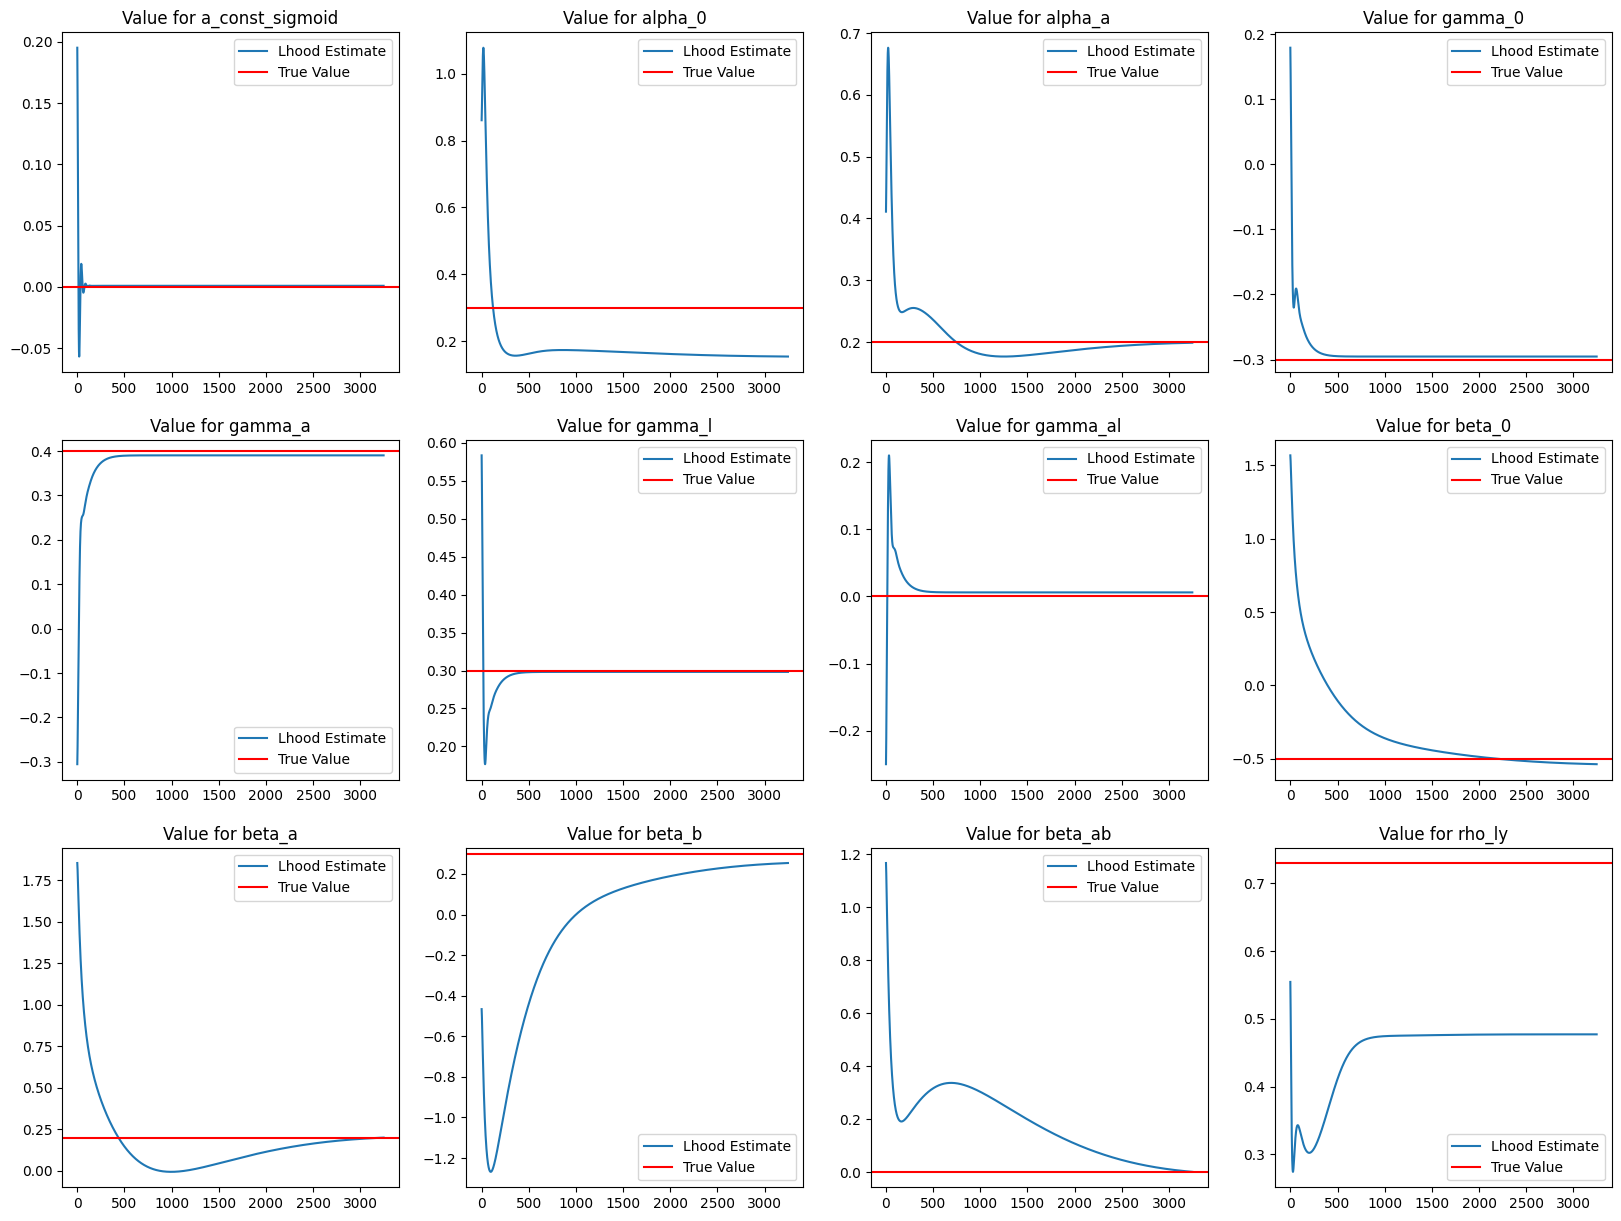

In [103]:
f, axs = plt.subplots(3, 4, figsize=(20, 15))

param_names = list(true_params.keys())
for i, ax in enumerate(f.axes):
    ax.plot(range(n_epochs+1), np.array(param_estimates[param_names[i]]), label='Lhood Estimate')
    ax.axhline(true_params[param_names[i]], color='r', label='True Value')
    # li.set_label('True Value')
    ax.title.set_text(f'Value for {param_names[i]}')
    ax.legend()

Not too shabby!